In [1]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
#Get Data
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
#Get all breaking balls 
bb = all_pitches[all_pitches['TaggedPitchType'].isin(['Curveball', 'Slider','Knuckleball'])]
print(bb.shape)

(80860, 167)


In [4]:
#Subset breaking balls into platoon splits
bb_rr = bb[(bb['PitcherThrows'] == 'Right') & (bb['BatterSide'] == 'Right')]
bb_rl = bb[(bb['PitcherThrows'] == 'Right') & (bb['BatterSide'] == 'Left')]
bb_lr = bb[(bb['PitcherThrows'] == 'Left') & (bb['BatterSide'] == 'Right')]
bb_ll = bb[(bb['PitcherThrows'] == 'Left') & (bb['BatterSide'] == 'Left')]

print(bb_rr.shape)
print(bb_rl.shape)
print(bb_lr.shape)
print(bb_ll.shape)

(38471, 167)
(17919, 167)
(12888, 167)
(11505, 167)


In [5]:
#Whiffs
bb_rr['whiff'] = np.where(bb_rr['PitchCall']=='StrikeSwinging',1,0)
bb_rl['whiff'] = np.where(bb_rl['PitchCall']=='StrikeSwinging',1,0)
bb_lr['whiff'] = np.where(bb_lr['PitchCall']=='StrikeSwinging',1,0)
bb_ll['whiff'] = np.where(bb_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_23528\96758115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_rr['whiff'] = np.where(bb_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_23528\96758115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_rl['whiff'] = np.where(bb_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_23528\96758115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [6]:
#Predictor Variables
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs. Righty Split

In [7]:
bb_rr_X = bb_rr[preds]
bb_rr_y = bb_rr['whiff']

In [8]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bb_rr_X, bb_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.36%


ROC AUC: 0.5219


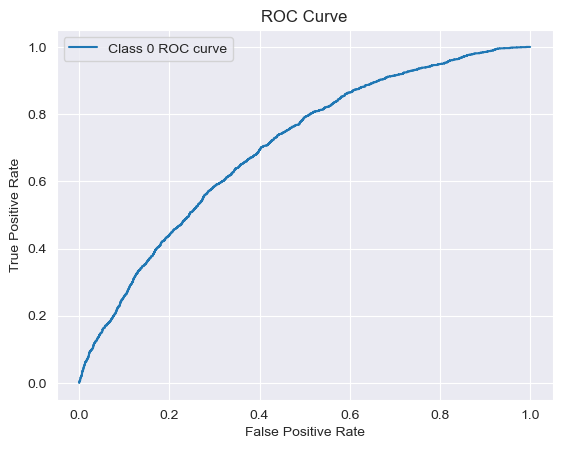

In [9]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [10]:
# Get unique values
unique_values = bb_rr['Pitcher'].unique()


#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bb_rr[bb_rr['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Tidwell, Blade' 'Magers, Alex' ... 'Pingeton, Anthony'
 'Causey, A.J.' "O'Brien Cameron"] 1466


In [11]:
def rr_bb_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bb_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [12]:
#Stuff+ for selected pitchers breaking balls in RHP v RHB split
rr_bb_stuff('Tilly, Cameron')

91.87367

Righty vs. Lefty Split

In [13]:
bb_rl_X = bb_rl[preds]
bb_rl_y = bb_rl['whiff']

In [14]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bb_rl_X, bb_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.32%


In [15]:
# Get unique values
unique_values = bb_rl['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bb_rl[bb_rl['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Hunley, Sean' 'Werner, Trevor' ... 'Stamos, Chris'
 'Causey, A.J.' "O'Brien Cameron"] 1209


In [16]:
def rl_bb_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bb_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [17]:
#Stuff+ for selected pitchers Breaking Balls in RHP v LHB split
rl_bb_stuff('Tilly, Cameron')

109.96456

Lefty vs. Righty Split

In [18]:
bb_lr_X = bb_lr[preds]
bb_lr_y = bb_lr['whiff']

In [19]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bb_lr_X, bb_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.01%


In [20]:
# Get unique values
unique_values = bb_lr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bb_lr[bb_lr['Pitcher'] == value] for value in unique_values}


['Menefee, Joseph' 'Walsh, Redmond' 'Wall, Chris' 'Robertson, Trae'
 'Adams, Aiden' 'LaCalameto, Kyle' 'Prayer, Cameron' 'Johnston, Will'
 'Holguin, Al' 'Gilreath, John' 'Rokose, Davis' 'Sullivan, Liam'
 'Woods, Jaden' 'Lohse, Ian' 'Shapiro, Joe' 'Sipe, Hunter'
 'Yntema, Graham' 'Atiya, Eli' 'Elliott, Hunter' 'Chronowski, Peter'
 'Dillard, Matt' 'Hanson, Sam' 'Seiler, Ben' 'Bauman, Tanner'
 'Hitt, Grayson' 'Furtado, Hunter' 'Goldstein, Charlie' 'Wagner, Luke'
 'Keevan, LJ' 'Cooper, Riley' 'Armbrustmacher, Dane' 'Ackenhausen, Nathan'
 'Davis, Tyler' 'Welch, Carter' 'Kimbrell, Jackson' 'Wansing, Troy'
 'Dayton, Cameron' 'Vail, Tommy' 'Clifton, Harrison' 'Davis, Alton'
 'Sibley, Joshua' 'Duke, Hayden' 'Wheeler, Trey' 'Lopez, Will'
 'Rivas, Xavier' 'Grome, Chris' 'Hogan, Kian' 'Sdao, Shane' 'Nelson, Drew'
 'Crotchfelt, Zach' 'Kraft, Ryan' 'Senders, Sammy' 'Zielinski, Eli'
 'Baker, Will' 'Jette, Jacob' 'Morris, Zack' 'Bates, Ethan'
 'Fitzgibbons, Jake' 'Nicholson, Gabe ' 'Bimbi, Jacob' 'Huf

In [21]:
def lr_bb_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bb_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [23]:
#Stuff+ for selected pitchers Breaking Balls in LHP v RHB split
lr_bb_stuff('Myers, Carson')

81.16161

Lefty vs. Lefty Split

In [24]:
bb_ll_X = bb_ll[preds]
bb_ll_y = bb_ll['whiff']

In [25]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bb_ll_X, bb_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.49%


In [26]:
# Get unique values
unique_values = bb_ll['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bb_ll[bb_ll['Pitcher'] == value] for value in unique_values}


['Menefee, Joseph' 'Walsh, Redmond' 'Johnston, Will' 'Wall, Chris'
 'Adams, Aiden' 'LaCalameto, Kyle' 'Prayer, Cameron' 'Holguin, Al'
 'Gilreath, John' 'Rokose, Davis' 'Sullivan, Liam' 'Woods, Jaden'
 'Lohse, Ian' 'Shapiro, Joe' 'Sipe, Hunter' 'Yntema, Graham'
 'Elliott, Hunter' 'Atiya, Eli' 'Chronowski, Peter' 'Dillard, Matt'
 'Hanson, Sam' 'Seiler, Ben' 'Bauman, Tanner' 'Hitt, Grayson'
 'Furtado, Hunter' 'Goldstein, Charlie' 'Baker, Will' 'Keevan, LJ'
 'Armbrustmacher, Dane' 'Cooper, Riley' 'Ackenhausen, Nathan'
 'Davis, Tyler' 'Morgan, Trey' 'Welch, Carter' 'Wansing, Troy'
 'Dayton, Cameron' 'Lamkin, Justin' 'Bothwell, Ty' 'Sheehan, Tommy'
 'Vail, Tommy' 'Clifton, Harrison' 'Davis, Alton' 'Sibley, Joshua'
 'Duke, Hayden' 'Wheeler, Trey' 'Phipps, Jackson' 'Szczepaniak, Drew'
 'Lopez, Will' 'Light, Nathan' 'Loftin, Bradley' 'Grome, Chris'
 'Rivas, Xavier' 'Hogan, Kian' 'Sdao, Shane' 'Nelson, Drew'
 'Crotchfelt, Zach' 'Kraft, Ryan' 'Reinke, Brian' 'Wagner, Luke'
 'Jette, Jacob' 'Morris

In [27]:
def ll_bb_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bb_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [29]:
#Stuff+ for selected pitchers Breaking Balls in LHP v LHB split
ll_bb_stuff('Myers, Carson')

111.53337